In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

***Task 1***
- using graph sata structure to represent part of the Piccadilly line.
- Edge label with the actual distances which is collected by using onine map services (Google Maps)

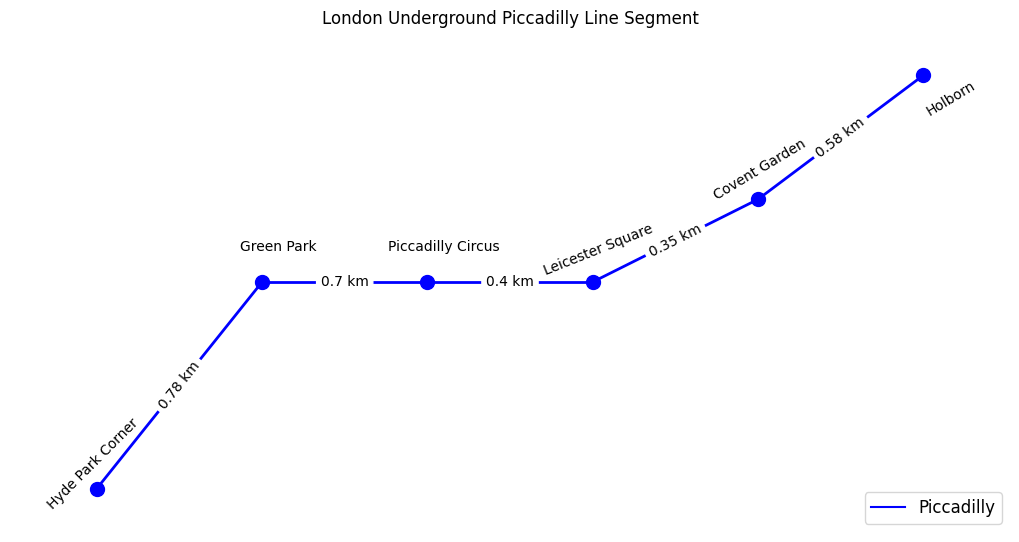

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def label_position(station, pos, neighbors, radius=0.15):
    # Get the position of the current station
    x, y = pos[station]

    # If no neighbors, return the original position
    if not neighbors:
        return x, y, 0

    # Choose the first neighbor to determine the angle
    neighbor = neighbors[-1]
    neighbor_x, neighbor_y = pos[neighbor]

    # Calculate the angle of the edge connecting the station to the neighbor
    angle = np.arctan2(neighbor_y - y, neighbor_x - x)

    # Place label a fixed distance above the edge
    label_x = x + radius * np.cos(angle + np.pi / 2)
    label_y = y + radius * np.sin(angle + np.pi / 2)

    # Rotate label to be parallel to the edge
    angle_deg = np.degrees(angle)
    
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180

    return label_x, label_y, angle_deg

# Define stations and their connections
stations = {
    'Hyde Park Corner': {'Green Park': 0.78},  # Distance in km
    'Green Park': {'Piccadilly Circus': 0.7},
    'Piccadilly Circus': {'Leicester Square': 0.4},
    'Leicester Square': {'Covent Garden': 0.35},
    'Covent Garden': {'Holborn': 0.58}
}

# Create a graph (G)
G = nx.Graph()
for station, connections in stations.items():
    for connected_station, dist in connections.items():
        G.add_edge(station, connected_station, weight=dist)

# Extract the distance for display
edge_labels = {(u, v): f"{dist['weight']} km" for u, v, dist in G.edges(data=True)}

# Set node positions
pos = {
    'Hyde Park Corner': (0, 0),
    'Green Park': (1, 1),
    'Piccadilly Circus': (2, 1),
    'Leicester Square': (3, 1),
    'Covent Garden': (4, 1.4),
    'Holborn': (5, 2)
}

# Draw graph (nodes, edges, labels)
plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=False, node_color='blue', node_size=100, 
        font_size=12, font_color='black', edge_color='blue', width=2)

# Draw edge labels (distances)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='black', font_size=10)

# Add node labels with calculated offsets and rotations
for station in pos:
    neighbors = list(G.neighbors(station))
    label_x, label_y, angle_deg = label_position(station, pos, neighbors, radius=0.15)
    
    plt.annotate(station, 
                 (label_x+0.1, label_y),  # Position with offset
                 fontsize=10, 
                 ha='center', 
                 color='black', 
                 rotation=angle_deg,  # Rotate the text to be parallel to the edge
                 rotation_mode='anchor')

# Add a legend for the line
plt.plot([], [], color='blue', label='Piccadilly')
plt.legend(loc='lower right', fontsize=12)

# Display the plot
plt.title("London Underground Piccadilly Line Segment")
plt.show()


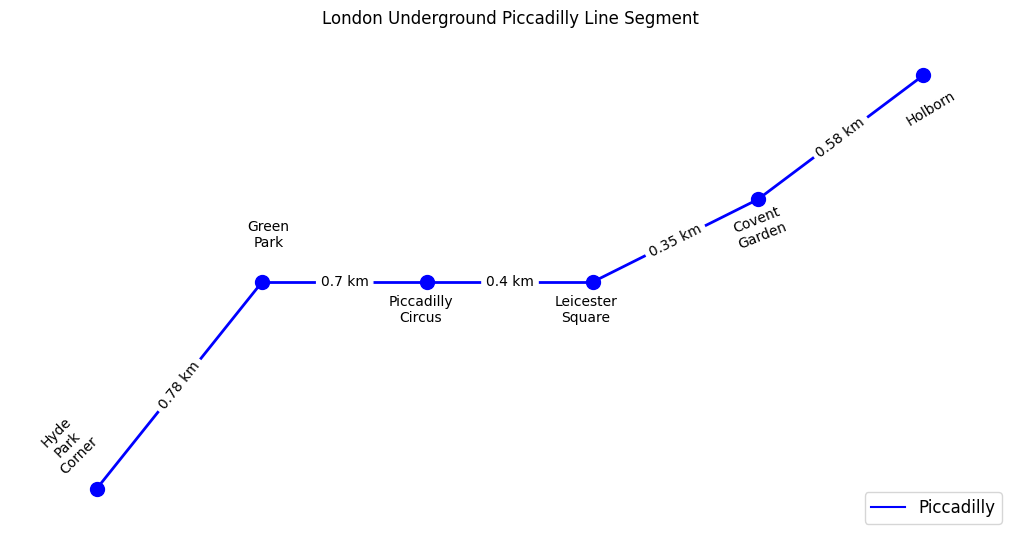

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def euclidean_distance(p1, p2):
    """ Calculate Euclidean distance between two points. """
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def find_best_label_position(node, pos, G, distance_offset=0.04, perpendicular_offset=0.18):
    """ Find the best label position around a node with an angle parallel to the closest edge. """
    x0, y0 = pos[node]
    # Find nearest neighbor to determine direction
    nearest_neighbor = min(G.neighbors(node), key=lambda n: euclidean_distance(pos[node], pos[n]), default=None)
    
    if not nearest_neighbor:
        return (x0, y0), 0

    # Calculate angle and position offset
    x1, y1 = pos[nearest_neighbor]
    angle = np.arctan2(y1 - y0, x1 - x0)
    perp_angle = angle + np.pi / 2
    label_x = x0 + distance_offset * np.cos(angle) + perpendicular_offset * np.cos(perp_angle)
    label_y = y0 + distance_offset * np.sin(angle) + perpendicular_offset * np.sin(perp_angle)
    
    # Convert angle to degrees and correct if upside down
    angle_deg = np.degrees(angle)
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180

    return (label_x, label_y), angle_deg

def split_label(text):
    """ Split a text label into multiple lines, one word per line if more than two words. """
    words = text.split()
    if len(words) >= 2:
        return '\n'.join(words)
    else:
        return text

# Define graph data and manually set positions
stations = {
    'Hyde Park Corner': {'Green Park': 0.78},
    'Green Park': {'Piccadilly Circus': 0.7},
    'Piccadilly Circus': {'Leicester Square': 0.4},
    'Leicester Square': {'Covent Garden': 0.35},
    'Covent Garden': {'Holborn': 0.58}
}

# Create and draw graph
G = nx.Graph((station, connected, {"weight": dist})
             for station, connections in stations.items()
             for connected, dist in connections.items())

pos = {'Hyde Park Corner': (0, 0), 
       'Green Park': (1, 1), 
       'Piccadilly Circus': (2, 1),
       'Leicester Square': (3, 1), 
       'Covent Garden': (4, 1.4), 
       'Holborn': (5, 2)}

fig = plt.figure(figsize=(10, 5))
nx.draw(G, pos, with_labels=False, node_color='blue', node_size=100, edge_color='blue', width=2)

# Draw edge and node labels
edge_labels = {(u, v): f"{dist['weight']} km" for u, v, dist in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

# Add node labels with calculated offsets and angles
for station in pos:
    (lx, ly), angle = find_best_label_position(station, pos, G)
    # Split the label if there are more than two words
    label = split_label(station)
    plt.text(lx, ly, label, fontsize=10, ha='center', color='black', rotation=angle, rotation_mode='anchor')

# Add legend and title
plt.plot([], [], color='blue', label='Piccadilly')
plt.legend(loc='lower right', fontsize=12)
plt.title("London Underground Piccadilly Line Segment")
plt.show()

fig.savefig('Figure/Task1.png')

***Task2***

In [4]:
from math import sin, cos, sqrt, atan2, radians
def Haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Compute differences in coordinates
    dif_lon = lon2 - lon1
    dif_lat = lat2 - lat1

    # Apply Haversine formula
    a = sin(dif_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(dif_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of Earth in kilometers
    R = 6373.0
    return R * c

In [5]:
# Load the datasets
station_data = pd.read_csv('RawStationData/London_stations.csv')
line_data = pd.read_csv('RawStationData/London_tube_lines.csv')

# Keep only relevant columns in station_data
station_data = station_data[['Station', 'Latitude', 'Longitude']]

# Step 1: Data Cleaning
# Merge the datasets based on station names
# Left merge to include only stations that are in both datasets
merged_data = line_data.merge(station_data, left_on='From Station', right_on='Station')
merged_data = merged_data.merge(station_data, left_on='To Station', right_on='Station', suffixes=('_From', '_To'))

# Define a function to calculate the distance between two stations
def calculate_distance(row):
    return round(Haversine(row['Latitude_From'], row['Longitude_From'], row['Latitude_To'], row['Longitude_To']), 2)

# Add a new column for distance
merged_data['Distance (km)'] = merged_data.apply(calculate_distance, axis=1)

# Drop unnecessary 'Station_From' and 'Station_To' columns
merged_data = merged_data.drop(columns=['Station_From', 'Station_To'])

# Step 2: Save the cleaned dataset to a CSV file
cleaned_dataset_filename = "StationData/cleaned_station_lines.csv"
merged_data.to_csv(cleaned_dataset_filename, index=False)
print(f"Cleaned dataset saved to '{cleaned_dataset_filename}'")

# Step 3: Filter the dataset for selected tube lines
selected_lines = ["Central", "Jubilee", "Piccadilly", "Circle"]
filtered_data = merged_data[merged_data['Tube Line'].isin(selected_lines)]

# Step 4: Save the filtered dataset to a CSV file
filtered_dataset_filename = "StationData/selected_tube_lines.csv"
filtered_data.to_csv(filtered_dataset_filename, index=False)
print(f"Filtered dataset saved to '{filtered_dataset_filename}'")

Cleaned dataset saved to 'StationData/cleaned_station_lines.csv'
Filtered dataset saved to 'StationData/selected_tube_lines.csv'


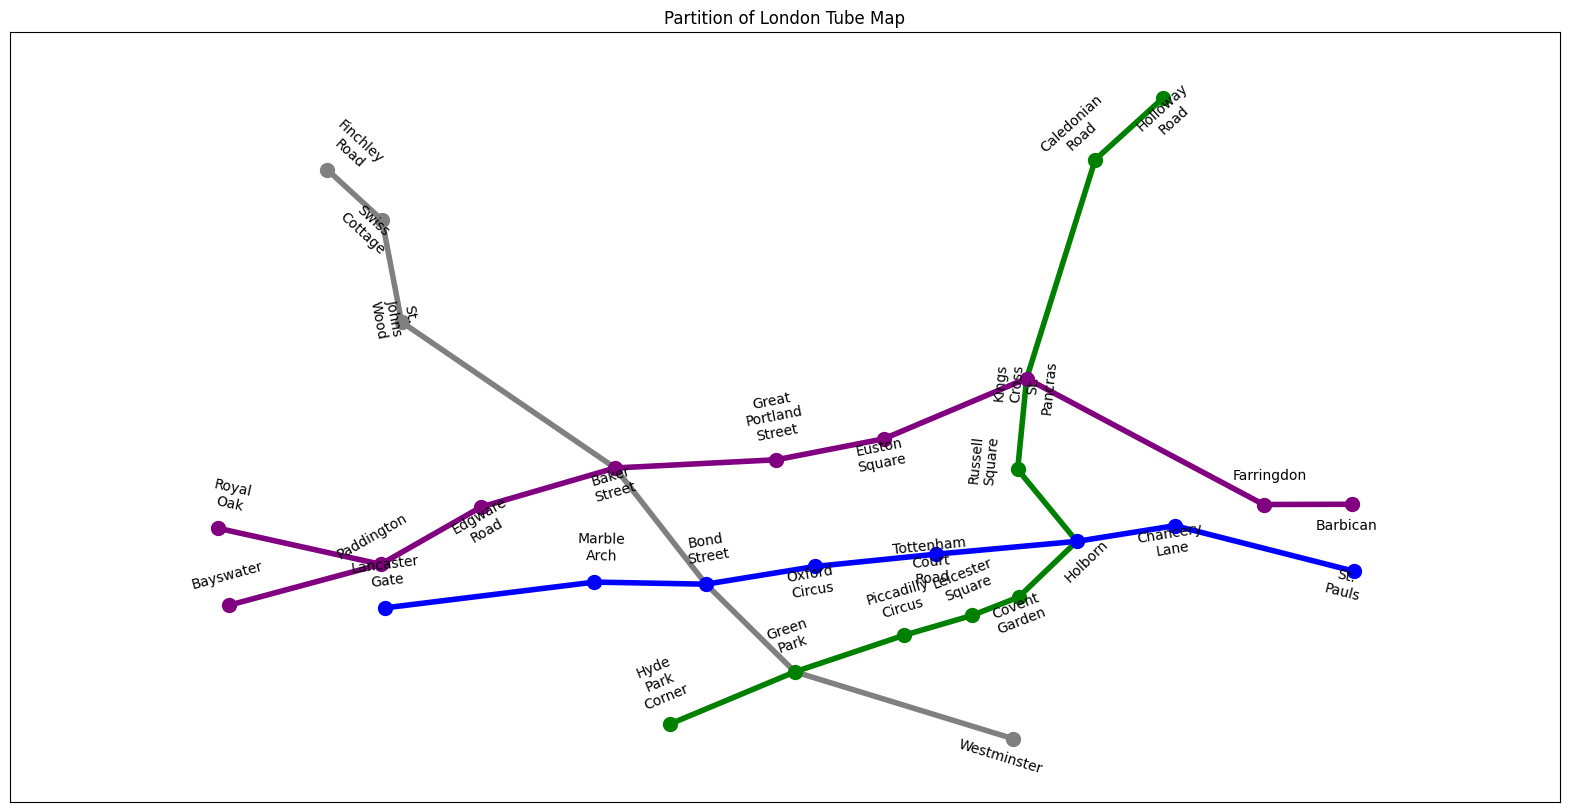

In [6]:
# Define line colors for plotting
line_colors = {
    "Central": "Blue", 
    "Jubilee": "Gray", 
    "Piccadilly": "Green", 
    "Circle": "Purple"
}

# Step 1: Load dataset
data = pd.read_csv('Task2Data/data.csv')  # Replace with your dataset filename

# Step 2: Create graph
G2 = nx.Graph()

# Add nodes and edges to the graph with scaled positions and line information
for _, row in data.iterrows():
    # Add nodes with positions and line color
    G2.add_node(row['From Station'], pos=(row['Longitude_From'], row['Latitude_From']), line=row['Tube Line'])
    G2.add_node(row['To Station'], pos=(row['Longitude_To'], row['Latitude_To']), line=row['Tube Line'])
    
    # Add edges with distance and line information
    G2.add_edge(
        row['From Station'], 
        row['To Station'], 
        weight=row['Distance (km)'], 
        line=row['Tube Line']
    )

# Extract positions for plotting
pos2 = nx.get_node_attributes(G2, 'pos')

# Create plot
plt.figure(figsize=(20, 10))

# Draw edges with line colors
for line, color in line_colors.items():
    edges = [(u, v) for u, v, d in G2.edges(data=True) if d['line'] == line]
    nx.draw_networkx_edges(G2, pos2, edgelist=edges, edge_color=color, width=4)

# Draw nodes with line colors
for line, color in line_colors.items():
    nodes = [node for node, data in G2.nodes(data=True) if data['line'] == line]
    nx.draw_networkx_nodes(G2, pos2, nodelist=nodes, node_color=color, node_size=100)

# Add node labels with calculated offsets and angles
for station in pos2:
    (lx, ly), angle = find_best_label_position(station, pos2, G2, distance_offset=0.0005, perpendicular_offset=0.002)
    label = split_label(station)  # Split the label into multiple lines if needed
    plt.text(lx, ly, label, fontsize=10, ha='center', color='black', rotation=angle, rotation_mode='anchor')

# Show plot
plt.title("Partition of London Tube Map")
plt.axis('equal')  # Maintain aspect ratio
plt.show()

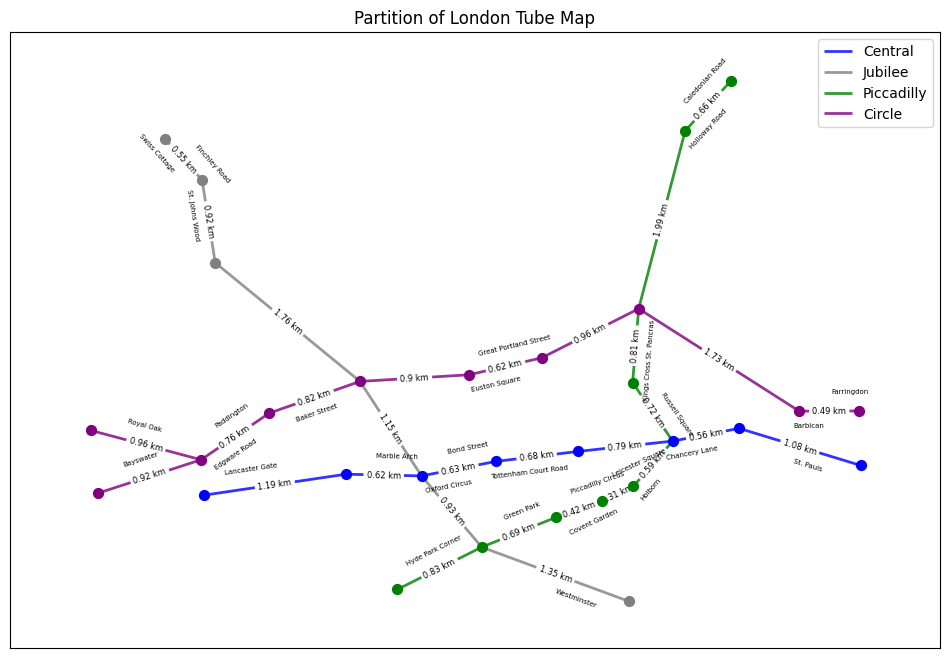

In [7]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

def euclidean_distance(p1, p2):
    """ Calculate Euclidean distance between two points. """
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def find_best_label_position(node, pos, G, distance_offset=0.03, perpendicular_offset=0.13):
    """ Find the best label position around a node with an angle parallel to the closest edge. """
    x0, y0 = pos[node]
    # Find nearest neighbor to determine direction
    nearest_neighbor = min(G.neighbors(node), key=lambda n: euclidean_distance(pos[node], pos[n]), default=None)
    
    if not nearest_neighbor:
        return (x0, y0), 0

    # Calculate angle and position offset
    x1, y1 = pos[nearest_neighbor]
    angle = np.arctan2(y1 - y0, x1 - x0)
    perp_angle = angle + np.pi / 2
    label_x = x0 + distance_offset * np.cos(angle) + perpendicular_offset * np.cos(perp_angle)
    label_y = y0 + distance_offset * np.sin(angle) + perpendicular_offset * np.sin(perp_angle)
    
    # Convert angle to degrees and correct if upside down
    angle_deg = np.degrees(angle)
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180

    return (label_x, label_y), angle_deg

class TubeMap:
    def __init__(self, data_file, line_colors):
        self.data_file = data_file
        self.line_colors = line_colors
        self.G = nx.Graph()
        self.pos = {}

    def load_data(self):
        """ Load the tube line data from a CSV file into the graph. """
        data = pd.read_csv(self.data_file)
        
        for _, row in data.iterrows():
            # Add nodes with positions and line color
            self.G.add_node(row['From Station'], pos=(row['Longitude_From'], row['Latitude_From']), line=row['Tube Line'])
            self.G.add_node(row['To Station'], pos=(row['Longitude_To'], row['Latitude_To']), line=row['Tube Line'])
            
            # Add edges with distance and line information
            self.G.add_edge(
                row['From Station'], 
                row['To Station'], 
                weight=row['Distance (km)'], 
                line=row['Tube Line']
            )

        # Extract positions for plotting
        self.pos = nx.get_node_attributes(self.G, 'pos')

    def plot_map(self, scale_factor=(1.5, 1.2)):
        """ Plot the tube map with nodes, edges, and central labels for each line. """
        # Scale positions independently for x and y axis
        scaled_pos = {station: (lon * scale_factor[0], lat * scale_factor[1]) for station, (lon, lat) in self.pos.items()}

        # Draw edges with line colors
        for line, color in self.line_colors.items():
            edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['line'] == line]
            nx.draw_networkx_edges(self.G, scaled_pos, edgelist=edges, edge_color=color, width=2, alpha=0.8, label=line)

            # Draw nodes with line colors
            nodes = [node for node, data in self.G.nodes(data=True) if data['line'] == line]
            nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=nodes, node_color=color, node_size=50)

        # Add node labels with calculated offsets and angles
        for station in self.pos:
            (lx, ly), angle = find_best_label_position(station, scaled_pos, self.G, distance_offset=0.0003, perpendicular_offset=0.0001)
            plt.text(lx, ly, station, fontsize=5, ha='center', color='black', rotation=angle, rotation_mode='anchor')
        edge_labels = {(u, v): f"{dist['weight']} km" for u, v, dist in self.G.edges(data=True)}
        nx.draw_networkx_edge_labels(self.G, scaled_pos, edge_labels=edge_labels, font_size=6, font_color='black')# Define line colors and key stations
# Define line colors and key stations
line_colors = {
    "Central": "Blue", 
    "Jubilee": "Gray", 
    "Piccadilly": "Green", 
    "Circle": "Purple"
}

# Create a TubeMap object and plot the map
tube_map = TubeMap(data_file='Task2Data/data.csv', line_colors=line_colors)
tube_map.load_data()

fig, ax = plt.subplots(figsize=(12, 8))
tube_map.plot_map(scale_factor=(0.05, 0.06))  # Scale x and y independently for better spread

plt.title("Partition of London Tube Map")
plt.axis('equal')  # Maintain aspect ratio
plt.legend(loc='best', fontsize=10)
plt.show()

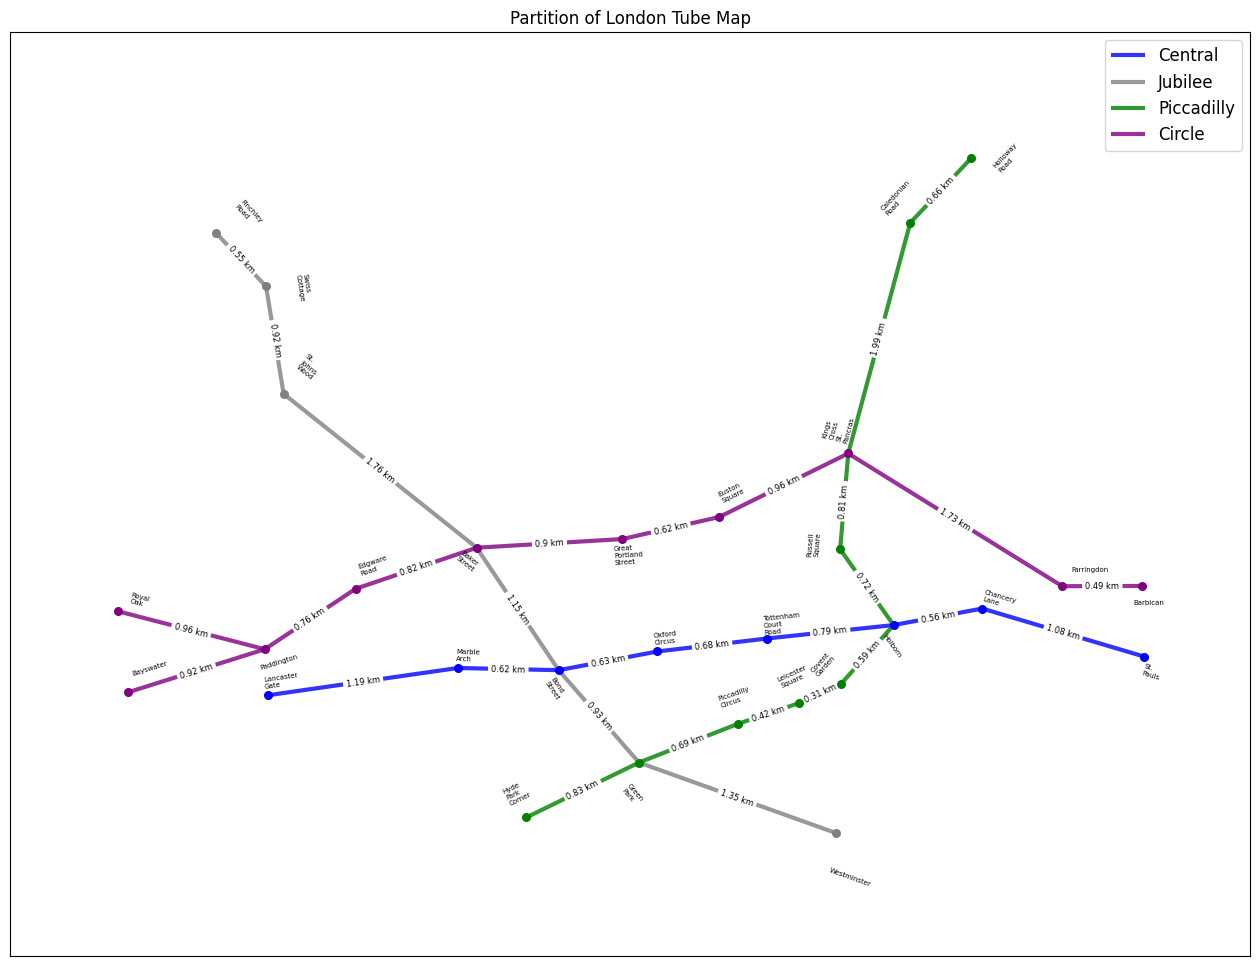

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np

def label_position(station, pos, neighbors, line, line_settings):
    # Get the position of the current station
    x, y = pos[station]

    # If no neighbors, return the original position
    if not neighbors:
        return x, y, 0

    # Choose the neighbor based on the 'dir' parameter in line_settings
    dir = line_settings[line].get("dir", 0)  # Default to 0 if not specified
    neighbor = neighbors[dir]
    neighbor_x, neighbor_y = pos[neighbor]

    # Calculate the angle of the edge connecting the station to the neighbor
    angle = np.arctan2(neighbor_y - y, neighbor_x - x)

    # Get custom radius and angle offset for this line
    radius = line_settings[line]["radius"]
    angle_offset = line_settings[line]["angle_offset"]

    # Adjust label position and angle based on line-specific settings
    label_x = x + radius * np.cos(angle + np.radians(angle_offset))
    label_y = y + radius * np.sin(angle + np.radians(angle_offset))

    # Rotate label to be parallel to the edge with a slight adjustment
    angle_deg = np.degrees(angle)
    if angle_deg > 90 or angle_deg < -90:
        angle_deg += 180

    return label_x, label_y, angle_deg

def split_label(text):
    """ Split a text label into multiple lines, one word per line if more than two words. """
    words = text.split()
    if len(words) >= 2:
        return '\n'.join(words)
    else:
        return text

class TubeMap:
    def __init__(self, data_file, line_colors):
        self.data_file = data_file
        self.line_colors = line_colors
        self.G = nx.Graph()
        self.pos = {}

    def load_data(self):
        """ Load the tube line data from a CSV file into the graph. """
        data = pd.read_csv(self.data_file)
        
        for _, row in data.iterrows():
            # Add nodes with positions and line color
            self.G.add_node(row['From Station'], pos=(row['Longitude_From'], row['Latitude_From']), line=row['Tube Line'])
            self.G.add_node(row['To Station'], pos=(row['Longitude_To'], row['Latitude_To']), line=row['Tube Line'])
            
            # Add edges with distance and line information
            self.G.add_edge(
                row['From Station'], 
                row['To Station'], 
                weight=row['Distance (km)'], 
                line=row['Tube Line']
            )

        # Extract positions for plotting
        self.pos = nx.get_node_attributes(self.G, 'pos')

    def plot_map(self, scale_factor=(1.5, 1.2), line_settings=None):
        """ Plot the tube map with nodes, edges, and central labels for each line. """
        if line_settings is None:
            line_settings = {}

        # Scale positions independently for x and y axis
        scaled_pos = {station: (lon * scale_factor[0], lat * scale_factor[1]) for station, (lon, lat) in self.pos.items()}

        # Draw edges with line colors
        for line, color in self.line_colors.items():
            edges = [(u, v) for u, v, d in self.G.edges(data=True) if d['line'] == line]
            nx.draw_networkx_edges(self.G, scaled_pos, edgelist=edges, edge_color=color, width=3, alpha=0.8, label=line)

            # Draw nodes with line colors
            nodes = [node for node, data in self.G.nodes(data=True) if data['line'] == line]
            nx.draw_networkx_nodes(self.G, scaled_pos, nodelist=nodes, node_color=color, node_size=30)

        # Add node labels with calculated offsets and angles
        for station in scaled_pos:
            line = self.G.nodes[station]['line']
            neighbors = list(self.G.neighbors(station))
            if neighbors:  # Only calculate label if there are neighbors
                label_x, label_y, angle_deg = label_position(station, scaled_pos, neighbors, line, line_settings)
                label = split_label(station)
                plt.text(label_x, label_y, label, 
                         fontsize=5, ha='left', va='center',
                         color='black', rotation=angle_deg, 
                         rotation_mode='anchor')
        edge_labels = {(u, v): f"{dist['weight']} km" for u, v, dist in self.G.edges(data=True)}
        nx.draw_networkx_edge_labels(self.G, scaled_pos, edge_labels=edge_labels, font_size=6, font_color='black')# Define line colors and key stations
line_colors = {
    "Central": "Blue", 
    "Jubilee": "Gray", 
    "Piccadilly": "Green", 
    "Circle": "Purple"
}

# Define specific settings for each line (adjust radius, angle offset, and direction to reduce overlaps)
line_settings = {
    "Central": {"radius": 0.007, "angle_offset": 100, "dir": 0},
    "Jubilee": {"radius": 0.02, "angle_offset": 100, "dir": -1},
    "Piccadilly": {"radius": 0.015, "angle_offset": 110, "dir": 0},
    "Circle": {"radius": 0.01, "angle_offset": 60, "dir": 0}
}

# Create a TubeMap object and plot the map
tube_map = TubeMap(data_file='Task2Data/data.csv', line_colors=line_colors)
tube_map.load_data()

fig, ax = plt.subplots(figsize=(16, 12))
tube_map.plot_map(scale_factor=(6, 7), line_settings=line_settings)  # Scale x and y independently for better spread

plt.title("Partition of London Tube Map")
plt.axis('equal')  # Maintain aspect ratio
plt.legend(loc='best', fontsize=12)
plt.show()


In [18]:
tube_df = pd.read_csv('StationData/cleaned_station_lines.csv')
tube_df['Tube Line'].unique()

array(['Bakerloo', 'C2C', 'Central', 'Chiltern Railways', 'Circle',
       'District', 'DLR', 'Elizabeth', 'Great Northern', 'Great Western',
       'Greater Anglia', 'Hammersmith and City', 'Heathrow Connect',
       'Heathrow Express', 'Jubilee', 'Liberty', 'Lioness',
       'London Midland', 'Metropolitan', 'Mildmay', 'Northern',
       'Piccadilly', 'South Western', 'Southeastern', 'Southern',
       'Suffragette', 'Thameslink', 'Tramlink', 'Victoria',
       'Waterloo and City', 'Weaver', 'Windrush'], dtype=object)

In [ ]:
# Define line colors and key stations
tube_line_colors = {
    'Bakerloo',
    'C2C',
    'Central',
    'Chiltern Railways',
    'Circle',
    'District',
    'DLR', 'Elizabeth', 'Great Northern', 'Great Western',
    'Greater Anglia', 'Hammersmith and City', 'Heathrow Connect',
       'Heathrow Express', 'Jubilee', 'Liberty', 'Lioness',
       'London Midland', 'Metropolitan', 'Mildmay', 'Northern',
       'Piccadilly', 'South Western', 'Southeastern', 'Southern',
       'Suffragette', 'Thameslink', 'Tramlink', 'Victoria',
       'Waterloo and City', 'Weaver', 'Windrush'
}

# Create a TubeMap object and plot the map
tube_df = TubeMap(data_file='Task2Data/data.csv', line_colors=line_colors)
tube_df.load_data()

fig, ax = plt.subplots(figsize=(12, 8))
tube_df.plot_map(scale_factor=(0.05, 0.06))  # Scale x and y independently for better spread

plt.title("Partition of London Tube Map")
plt.axis('equal')  # Maintain aspect ratio
plt.legend(loc='best', fontsize=10)
plt.show()